# Content-Based Product Recommendation System for Fashion Items
- **Nama:** Laila Wulandari
- **Email:** lailawulandari0811@gmail.com
- **ID Dicoding:** laila_wulandari

# 1. Business Understanding

## 1. Problem Statements

1. Kompleksitas navigasi produk dalam katalog besar seperti Myntra menyebabkan rendahnya efisiensi pencarian dan kesulitan menemukan item dengan atribut spesifik.
2. Ketergantungan collaborative filtering pada riwayat interaksi membuatnya tidak efektif untuk produk baru (cold-start) dan item niche.

## 2. Goals

1.  Mengembangkan sistem rekomendasi berbasis konten yang menyaring banyak produk menjadi 5 teratas dengan kemiripan di atas 60% menggunakan fitur intrinsik.
2. Mengoptimalkan kualitas rekomendasi hingga mencapai Precision@5 dan nDCG@5 lebih dari 60% untuk menunjukkan relevansi dan urutan produk yang baik.


## 3. Solution Statements

Solusi 1: Cosine Similarity
Menggunakan TF-IDF dari gabungan deskripsi, merek, dan warna produk untuk menghitung kemiripan berdasarkan arah vektor.

Solusi 2: Euclidean Distance
Menggunakan TF-IDF dan menghitung jarak antar produk dalam ruang vektor untuk menentukan kemiripan.


Kode ini mengimpor **library utama** untuk membangun sistem rekomendasi berbasis teks. **Pandas dan NumPy** digunakan untuk manipulasi data, **Matplotlib dan Seaborn** membantu dalam visualisasi, sementara **TF-IDF dan CountVectorizer** digunakan untuk ekstraksi fitur teks. **NLTK** berperan dalam preprocessing teks dengan stopwords dan stemming, sedangkan **Cosine Similarity dan Euclidean Distance** digunakan untuk mengukur kemiripan antar produk. **Warnings** dinonaktifkan untuk menghindari gangguan dalam eksekusi.


In [3]:
# --- Manipulasi Data ---
import pandas as pd
import numpy as np
# --- Visualisasi Data ---
import matplotlib.pyplot as plt
import seaborn as sns
# --- Preprocessing Teks ---
import re
# --- Ekstraksi Fitur Teks ---
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# --- Stopwords dan Stemming ---
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# --- Cosine Similarity ---
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# --- Penanganan Warning ---
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 3. Data Loading
Pada tahap ini dataset akan dimuat, dataset yang digunakan adalah Fashion Clothing Products Dataset.

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/LailaWulandarii/content-based-filtering/refs/heads/main/myntra_products_catalog.csv")

# 4. Exploratory Data Analysis
Tahap ini bertujuan untuk melakukan analisis data untuk memahami karakteristik data sebelum dilakukan permodelan.

In [5]:
#Melihat 5 data pertama
data.head()

,ProductID,ProductName,ProductBrand,Gender,Price (INR),NumImages,Description,PrimaryColor
0,10017413,DKNY Unisex Black & Grey Printed Medium Trolle...,DKNY,Unisex,11745,7,"Black and grey printed medium trolley bag, sec...",Black
1,10016283,EthnoVogue Women Beige & Grey Made to Measure ...,EthnoVogue,Women,5810,7,Beige & Grey made to measure kurta with churid...,Beige
2,10009781,SPYKAR Women Pink Alexa Super Skinny Fit High-...,SPYKAR,Women,899,7,Pink coloured wash 5-pocket high-rise cropped ...,Pink
3,10015921,Raymond Men Blue Self-Design Single-Breasted B...,Raymond,Men,5599,5,Blue self-design bandhgala suitBlue self-desig...,Blue
4,10017833,Parx Men Brown & Off-White Slim Fit Printed Ca...,Parx,Men,759,5,"Brown and off-white printed casual shirt, has ...",White


Tahapan pertama yang dilakukan dalam EDA, yaitu melihat 5 data pertama pada dataset untuk keseluruhan kolom.

In [6]:
#Melihat informasi umum dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     12491 non-null  int64 
 1   ProductName   12491 non-null  object
 2   ProductBrand  12491 non-null  object
 3   Gender        12491 non-null  object
 4   Price (INR)   12491 non-null  int64 
 5   NumImages     12491 non-null  int64 
 6   Description   12491 non-null  object
 7   PrimaryColor  11597 non-null  object
dtypes: int64(3), object(5)
memory usage: 780.8+ KB


Tahapan selanjutnya adalah mengecek informasi umum dataset. Berdasarkan hasil tersebut, dataset yang digunakan memiliki 8 kolom numerikal dan kategorikal dengan total 12491 data.

In [7]:
#Cek data kosong
print("Jumlah missing value:")
print(data.isnull().sum())

Jumlah missing value:
ProductID         0
ProductName       0
ProductBrand      0
Gender            0
Price (INR)       0
NumImages         0
Description       0
PrimaryColor    894
dtype: int64


Pada tahap ini ditemukan adanya missing value pada kolom PrimaryColor sebanyak 894, yang nantinya akan ditangani sbeelum masuk ke tahap modeling.

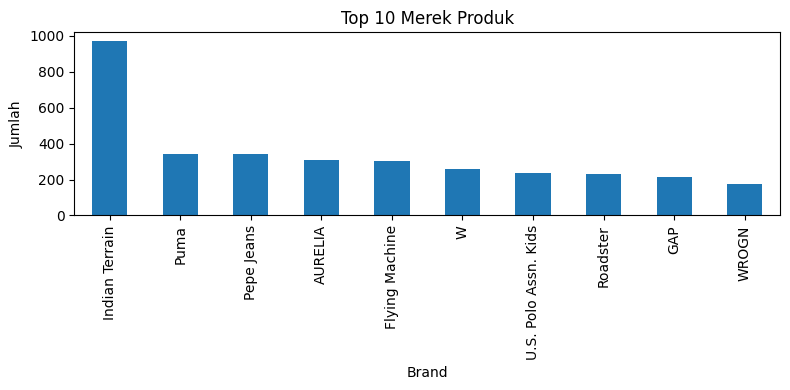

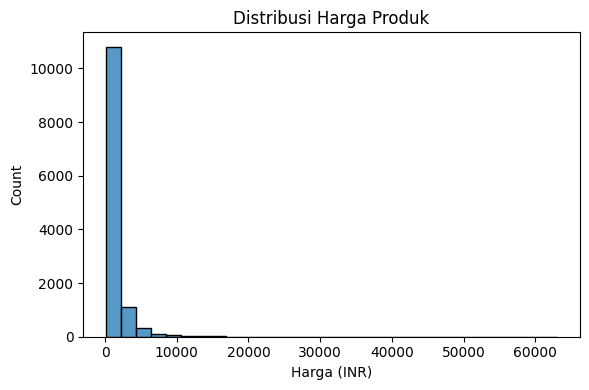

In [8]:
#Visualisasi untuk 10 merek produk teratas dengan grafik batang
plt.figure(figsize=(8, 4))
data['ProductBrand'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Merek Produk")
plt.ylabel("Jumlah")
plt.xlabel("Brand")
plt.tight_layout()
plt.show()

#Visualisasi histogram untuk melihat distribusi harga produk
plt.figure(figsize=(6, 4))
sns.histplot(data['Price (INR)'], bins=30)
plt.title("Distribusi Harga Produk")
plt.xlabel("Harga (INR)")
plt.tight_layout()
plt.show()


Selanjutnya dilakukan visualisasi data, berikut hasilnya:

*   Top 10 merek = Indian Terrain mendominasi dengan jumlah produk terbanyak, sementara merek lain seperti Puma dan Pepe Jeans bersaing cukup ketat. Sebagian besar merek memiliki kurang dari 400 produk, menunjukkan variasi popularitas di pasar.
*   Distribusi harga produk = Harga produk sebagian besar terkonsentrasi pada rentang tertentu, menunjukkan kecenderungan pasar terhadap harga spesifik. Lonjakan pada titik harga tertentu bisa mengindikasikan popularitas atau segmentasi konsumen.

# 5. Preprocessing
Pada tahap ini dilakukan preprocessing data untuk menyiapkan fitur dan target yang optimal untuk pemodelan, membagi dataset secara proporsional dan melakukan standardisasi nilai fitur.


In [9]:
#Mengisi nilai kosong pada kolom 'PrimaryColor' dengan 'Unknown'
data['PrimaryColor'] = data['PrimaryColor'].fillna('Unknown')

Kode di atas menangani data kosong pada kolom 'PrimaryColor', mengisinya  dengan string 'Unknown'

In [10]:
def clean_text(text):
    if not isinstance(text, str):  #Memastikan input adalah string
        return ""

    #Menghapus karakter khusus dan angka, lalu mengubah ke huruf kecil
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())

    #Daftar stopwords khusus untuk domain fashion
    custom_stopwords = set(stopwords.words('english')) | {
        'size', 'cm', 'inch', 'pack', 'item', 'made'
    }

    #Tokenisasi dan penghapusan stopwords
    words = [word for word in text.split()
             if word not in custom_stopwords and len(word) > 2]

    #Stemming untuk menyederhanakan kata
    stemmer = SnowballStemmer("english")
    words = [stemmer.stem(word) for word in words]

    return " ".join(words)

Kode di atas untuk membersihkan teks dengan stopwords khusus, serta menerapkan stemming untuk menyederhanakan kata

In [11]:
#Mengekstrak kata kunci warna dari deskripsi produk
color_keywords = r'\b(black|blue|red|green|yellow|white|gray|pink|navy|maroon)\b'
data['extracted_color'] = data['Description'].str.extract(color_keywords, flags=re.IGNORECASE)

Kode di atas untuk mengekstrak warna dari kolom deskripsi.

In [12]:
#Meningkatkan bobot kata kunci penting
def boost_keywords(text):
    keywords = {
        'raymond': 'raymond raymond raymond',
        'dkny': 'dkny dkny dkny',
        'black': 'black black',
        'design': 'design design'
    }
    for k, v in keywords.items():
        text = text.replace(k, v)
    return text

Kode di atas untuk meningkatkan bobot pada kata kunci penting.

In [13]:
#Menggabungkan informasi produk untuk membentuk fitur teks
data['text_features'] = (
    data['ProductName'] + " " +
    data['Description'] + " " +
    data['ProductBrand'] + " " +
    data['PrimaryColor'] + " " +
    data['extracted_color'].fillna('')
)

Kode di atas berfungsi untuk menggabungkan informasi produk dalam pembentukan fitur teks.

In [14]:
#Menerapkan pembersihan teks dan peningkatan kata kunci
data['text_features'] = data['text_features'].apply(clean_text).apply(boost_keywords)

Kode di atas untuk menerapkan pembersihan teks dan peningkatan kata kunci yang telah dilakukan sebelumnya.

In [15]:
#Membuat objek TF-IDF Vectorizer dengan stopwords bahasa Inggris
tfidf = TfidfVectorizer(stop_words='english')

#Mengubah teks fitur menjadi representasi numerik TF-IDF
tfidf_matrix = tfidf.fit_transform(data['text_features'])

Kode di atas untuk mengubah teks menjadi numerik dengan TF-IDF dengan stopwords bahasa inggris.

## 6. Modeling

Tahap modeling dilakukan dengan menggunakan pendekatan Cosine Similarity dan Euclidean Distance.

### 6.1 Cosine Similarity

Kode ini menghitung Cosine Similarity untuk menemukan tingkat kemiripan antar semua item dalam dataset berdasarkan representasi teks TF-IDF, memungkinkan sistem rekomendasi berbasis konten menghasilkan produk yang paling relevan.

In [16]:
#Menghitung cosine similarity antar semua item
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

### 6.2 Euclidean Distance

Kode ini menghitung Euclidean Distance antara produk berdasarkan representasi TF-IDF, di mana nilai yang lebih kecil menunjukkan kemiripan lebih tinggi karena produk berada lebih dekat dalam ruang vektor.

In [17]:
#Hitung Euclidean Distance antar produk
euclidean_sim = euclidean_distances(tfidf_matrix, tfidf_matrix)


## 7. Top-N Recommendation

Kode ini mencari 5 produk paling mirip dengan 'Casual shirt' menggunakan Cosine Similarity dan Euclidean Distance. Kedua metode menghasilkan rekomendasi yang hampir identik, menunjukkan bahwa produk dalam dataset memiliki deskripsi yang sangat mirip. Cosine Similarity menangkap hubungan semantik antar kata, sementara Euclidean Distance mengukur kedekatan numerik dalam ruang vektor.

In [24]:
#Fungsi untuk memberikan rekomendasi produk
def recommended(product_name, similarity_matrix, top_n=5, similarity_type='cosine'):
    #Temukan index dari produk
    idx = data[data['ProductName'].str.contains(product_name, case=False, na=False)].index[0]

    #Ambil skor similarity
    sim_scores = list(enumerate(similarity_matrix[idx]))

    #Urutkan berdasarkan jenis similarity
    if similarity_type == 'cosine':
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    else:  #untuk euclidean dan jarak lain
        sim_scores = sorted(sim_scores, key=lambda x: x[1])

    #Ambil top_n produk selain dirinya sendiri
    top_indices = [i[0] for i in sim_scores if i[0] != idx][:top_n]

    return data['ProductName'].iloc[top_indices].tolist()

#Produk yang akan dicari rekomendasinya
produk_input = "Casual Shirt"

#Menampilkan rekomendasi berdasarkan Cosine Similarity
print("\nRekomendasi dengan Cosine Similarity:")
print(recommended(produk_input, cosine_sim_matrix, top_n=5, similarity_type='cosine'))

#Menampilkan rekomendasi berdasarkan Euclidean Distance
print("\nRekomendasi dengan Euclidean Distance:")
print(recommended(produk_input, euclidean_sim, top_n=5, similarity_type='euclidean'))


Rekomendasi dengan Cosine Similarity:
['Parx Men Off-White & Blue Slim Fit Printed Casual Shirt', 'Parx Men Blue & Off-White Slim Fit Printed Casual Shirt', 'Parx Men Blue & Off-White Slim Fit Printed Casual Shirt', 'Parx Men White Slim Fit Printed Casual Shirt', 'Parx Men Pink & Off-White Slim Fit Printed Casual Shirt']

Rekomendasi dengan Euclidean Distance:
['Parx Men Off-White & Blue Slim Fit Printed Casual Shirt', 'Parx Men Blue & Off-White Slim Fit Printed Casual Shirt', 'Parx Men Blue & Off-White Slim Fit Printed Casual Shirt', 'Parx Men White Slim Fit Printed Casual Shirt', 'Parx Men Pink & Off-White Slim Fit Printed Casual Shirt']


## 8. Evaluation

Pada tahap ini dilakukan evaluasi dengan Precision@K yang fokus pada jumlah item relevan dan NDCG@K untuk mempertimbangkan posisi item dalam daftar rekomendasi.


In [19]:
#Fungsi Precision@K
def precision_at_k(recommended_indices, relevant_indices, k=5):
    recommended_k = recommended_indices[:k]  #Ambil top-k rekomendasi
    relevant_set = set(relevant_indices)  #Konversi daftar relevan ke set untuk pencarian cepat
    hits = sum(1 for idx in recommended_k if idx in relevant_set)  #Hitung jumlah rekomendasi yang benar
    return hits / k  #Precision dihitung sebagai rasio rekomendasi yang benar terhadap k

#Fungsi nDCG@K
def ndcg_at_k(recommended_indices, relevant_indices, k=5):
    dcg = 0.0
    relevant_set = set(relevant_indices)  #Konversi daftar relevan ke set
    for i, idx in enumerate(recommended_indices[:k]):
        if idx in relevant_set:
            dcg += 1 / np.log2(i + 2)  #Hitung DCG berdasarkan posisi item relevan
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant_indices), k)))  #Hitung IDCG sebagai ideal DCG
    return dcg / idcg if idcg > 0 else 0.0  #Normalisasi DCG untuk mendapatkan nDCG

Kode ini mengevaluasi kualitas rekomendasi dengan Precision@K, yang mengukur proporsi item relevan dalam top-k rekomendasi, dan nDCG@K, yang mempertimbangkan posisi item relevan untuk memberikan bobot lebih tinggi pada rekomendasi yang muncul lebih awal.

In [20]:
#Menentukan nilai K untuk evaluasi
k = 5

#List untuk menyimpan skor evaluasi
precision_scores_cosine = []
ndcg_scores_cosine = []
precision_scores_euclidean = []
ndcg_scores_euclidean = []

#Pilih 100 sampel acak dari dataset untuk evaluasi
sample_indices = np.random.choice(data.index, size=100, replace=False)

for idx in sample_indices:
    #Ambil brand dan gender produk saat ini
    current_brand = data.loc[idx, 'ProductBrand']
    current_gender = data.loc[idx, 'Gender']

    #Temukan produk relevan dengan brand dan gender yang sama, kecuali produk itu sendiri
    relevant = data[
        (data['ProductBrand'] == current_brand) &
        (data['Gender'] == current_gender) &
        (data.index != idx)
    ].index.tolist()

    #Hitung skor kemiripan menggunakan Cosine Similarity
    sim_scores_cosine = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores_cosine = sorted(sim_scores_cosine, key=lambda x: x[1], reverse=True)
    recommended_cosine = [i[0] for i in sim_scores_cosine[1:k+1]]

    #Hitung skor kemiripan menggunakan Euclidean Distance
    sim_scores_euclidean = list(enumerate(euclidean_sim[idx]))
    sim_scores_euclidean = sorted(sim_scores_euclidean, key=lambda x: x[1])  #Euclidean: jarak kecil = lebih mirip
    recommended_euclidean = [i[0] for i in sim_scores_euclidean[1:k+1]]

    #Evaluasi rekomendasi dengan Precision@K dan nDCG@K untuk Cosine Similarity
    precision_scores_cosine.append(precision_at_k(recommended_cosine, relevant, k))
    ndcg_scores_cosine.append(ndcg_at_k(recommended_cosine, relevant, k))

    #Evaluasi rekomendasi dengan Precision@K dan nDCG@K untuk Euclidean Distance
    precision_scores_euclidean.append(precision_at_k(recommended_euclidean, relevant, k))
    ndcg_scores_euclidean.append(ndcg_at_k(recommended_euclidean, relevant, k))

Kode ini mengevaluasi kualitas rekomendasi dengan Precision@K dan nDCG@K, menggunakan Cosine Similarity dan Euclidean Distance untuk mengukur kemiripan produk berdasarkan deskripsi teks. Cosine Similarity lebih efektif dalam menangkap hubungan semantik antar produk, sementara Euclidean Distance mengukur kedekatan numerik dalam ruang vektor.

In [25]:
#Cetak rata-rata Precision@K dan nDCG@K untuk Cosine Similarity
print(f"Average Precision@{k} - Cosine Similarity: {np.mean(precision_scores_cosine):.4f}")
print(f"Average nDCG@{k} - Cosine Similarity: {np.mean(ndcg_scores_cosine):.4f}\n")

#Cetak rata-rata Precision@K dan nDCG@K untuk Euclidean Distance
print(f"Average Precision@{k} - Euclidean Distance: {np.mean(precision_scores_euclidean):.4f}")
print(f"Average nDCG@{k} - Euclidean Distance: {np.mean(ndcg_scores_euclidean):.4f}")

Average Precision@5 - Cosine Similarity: 0.6460
Average nDCG@5 - Cosine Similarity: 0.6804

Average Precision@5 - Euclidean Distance: 0.6460
Average nDCG@5 - Euclidean Distance: 0.6804


Hasil ini menunjukkan bahwa Cosine Similarity dan Euclidean Distance memberikan performa yang sama dalam merekomendasikan produk, dengan Precision@5 sekitar 64.6%—yang berarti 3-4 dari 5 rekomendasi berada dalam daftar produk relevan. nDCG@5 sebesar 68.04% menunjukkan bahwa posisi item relevan dalam daftar rekomendasi cukup baik, tetapi masih ada ruang untuk perbaikan dalam pengurutan hasil agar produk paling relevan muncul lebih awal.